In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Sentiment Anlaysis

이 노트북은 한국어 문장 분류 태스크를 파이토치로 구현하며 Hugging Face를 실전 감각으로 익히는 것을 목표로 합니다.

## 데이터셋: KLUE-YNAT (뉴스 토픽 분류)
- 과제 유형: 단일 레이블 문장 분류 (7개 카테고리)
- 레이블 예시: IT 과학, 경제, 사회, 생활문화, 세계, 스포츠, 정치
- 왜 YNAT인가?
    - 한국어 공개 벤치마크로 재현성이 높고, 분류 태스크의 전형적 전처리, 평가 흐름을 학습하기 좋다.


## 학습 목표
1. Hugging Face Datasets/Transformers를 이용한 엔드투엔드 실험 파이프라인 확립
2. 동일 태스크를 PyTorch 커스텀 루프 vs. Trainer로 구현하여 개발 생산성/제어력 비교

## 0. Library 설치

In [2]:
!pip install transformers==4.41.2 evaluate==0.4.0 datasets==2.20.0 scikit-learn==1.4.2
!pip install accelerate -U
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokeni

## 1. Code

### 1) 데이터셋 로드

In [3]:
from datasets import load_dataset, DatasetDict
import pandas as pd

dataset = load_dataset('klue', 'ynat')
print(dataset)
print(f"샘플: {dataset['train'][0]}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date'],
        num_rows: 9107
    })
})
샘플: {'guid': 'ynat-v1_train_00000', 'title': '유튜브 내달 2일까지 크리에이터 지원 공간 운영', 'label': 3, 'url': 'https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947', 'date': '2016.06.30. 오전 10:36'}


### 2) EDA

label list: ['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']
id2label: {0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}
label2id: {'IT과학': 0, '경제': 1, '사회': 2, '생활문화': 3, '세계': 4, '스포츠': 5, '정치': 6}
train 데이터셋의 텍스트 결측치: 0
train 데이터셋의 레이블 결측치: 0
validation 데이터셋의 텍스트 결측치: 0
validation 데이터셋의 레이블 결측치: 0


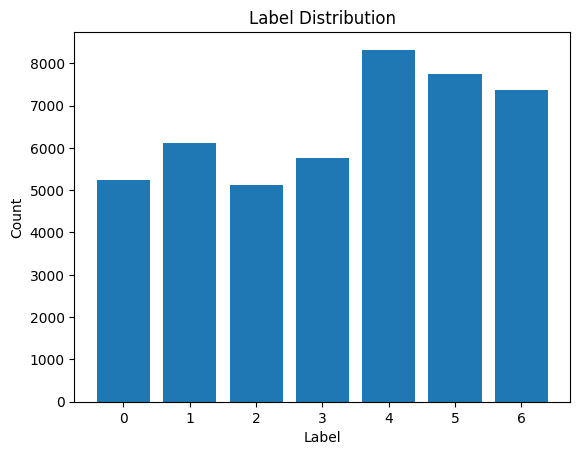

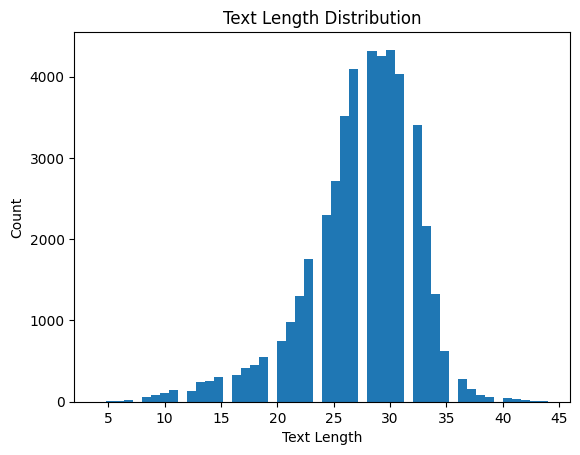

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

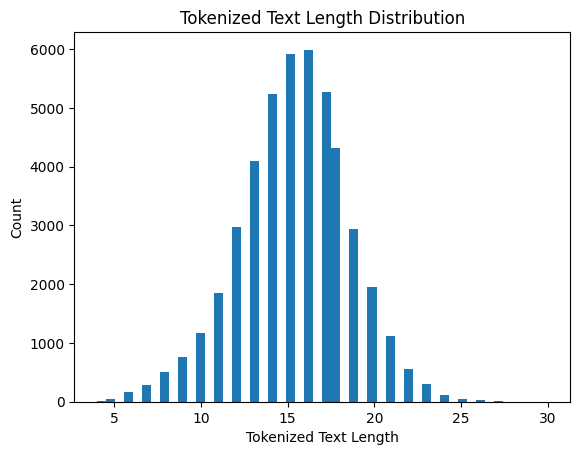

최대 길이: 30
평균 길이: 15.392836814221289
최소 길이: 4


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# 2.1 텍스트, 레이블 컬럼 지정 및 레이블 리스트, id2label, label2id 설정
TEXT_COL, LABEL_COL = 'title', 'label'
label_list = dataset['train'].features[LABEL_COL].names
print(f"label list: {label_list}")

id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

# 2.2 텍스트, 레이블 결측치 확인
for split in dataset:
    df = pd.DataFrame(dataset[split])
    missing_text = df[TEXT_COL].isnull().sum() + (df[TEXT_COL].astype(str).str.strip() == '').sum()
    missing_label = df[LABEL_COL].isnull().sum()
    print(f"{split} 데이터셋의 텍스트 결측치: {missing_text}")
    print(f"{split} 데이터셋의 레이블 결측치: {missing_label}")

# 2.3 레이블 분포
train_labels = dataset['train'][LABEL_COL]
label_counts = np.unique(train_labels, return_counts=True)
plt.bar(label_counts[0], label_counts[1])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

# 2.4 문자 길이 분포
train_texts = dataset['train'][TEXT_COL]
text_lengths = [len(text) for text in train_texts]
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Text Length Distribution')
plt.show()

# 2.5 토큰화가 된 후의 문자 길이 분포
from transformers import AutoTokenizer
MODEL_NAME = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
lengths = [len(tokenizer.encode(x)) for x in train_texts]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Text Length')
plt.ylabel('Count')
plt.title('Tokenized Text Length Distribution')
plt.show()
print(f"최대 길이: {max(lengths)}")
print(f"평균 길이: {np.mean(lengths)}")
print(f"최소 길이: {min(lengths)}")

### 3) Preprocessing

- 결측치 처리
- 토크나이저 정의
- 데이터 분할
- batchize

In [5]:
from transformers import AutoTokenizer, DataCollatorWithPadding

# 3.1 결측치 처리: text NaN/빈문장 제거
def not_empty(ex):
    s = ex[TEXT_COL]
    if s is None:
        return False
    s = str(s).strip()
    return len(s) > 0

dataset = dataset.filter(not_empty)
print(dataset)

# 3.2 토크나이저 및 collator 정의
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"tokenizer: {tokenizer}")
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3.3 데이터 분할
split_data = dataset['train'].train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': split_data['train'],
    'validation': split_data['test'],
    'test': dataset['validation']
})
print(f"분할후 데이터셋: {dataset}")

# 3.4 토크나이저 함수 정의
MAX_LEN = 30
def tokenize_func(examples):
    return tokenizer(examples[TEXT_COL], truncation=True, max_length=30)

tokenized = dataset.map(tokenize_func, batched=True, remove_columns=['guid', 'title', 'url', 'date'])
print(f"tokenized dataset: {tokenized}")

Filter:   0%|          | 0/45678 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9107 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date'],
        num_rows: 9107
    })
})
tokenizer: BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, sp

Map:   0%|          | 0/36542 [00:00<?, ? examples/s]

Map:   0%|          | 0/9136 [00:00<?, ? examples/s]

Map:   0%|          | 0/9107 [00:00<?, ? examples/s]

tokenized dataset: DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 36542
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9136
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9107
    })
})


### 4) 모델 및 학습 설정

In [25]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_list), id2label=id2label, label2id=label2id)
print(f"model: {model}")

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print(f"No GPU available, using the CPU instead.")

model.to(device)

print(f"model: {model}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model: BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

### 5) 데이터 로더 설정

In [26]:
print(f"학습 데이터: {tokenized['train']}")
print(f"검증 데이터: {tokenized['validation']}")
print(f"테스트 데이터: {tokenized['test']}")

학습 데이터: Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36542
})
검증 데이터: Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9136
})
테스트 데이터: Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9107
})


In [27]:
from torch.utils.data import DataLoader

def _to_dataloader(dataset, collator, batch_size, shuffle=False):
    return DataLoader(
        dataset,
        collate_fn=collator,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True
    )

train_loader = _to_dataloader(tokenized['train'], collator, batch_size=64, shuffle=True)
valid_loader = _to_dataloader(tokenized['validation'], collator, batch_size=64, shuffle=False)
test_loader = _to_dataloader(tokenized['test'], collator, batch_size=64, shuffle=False)

print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

571
143
143


### 6) 모델 학습

In [39]:
from transformers import AdamW

# Optimizer 선택
optimizer = AdamW(model.parameters(), lr=5e-5)

# Epochs
epochs = 5

/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch
from tqdm import tqdm

def metrics(preds, labels):

    y_pred, y_true = preds, labels

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_weighted': f1_weighted
    }

In [41]:
def train(model, train_loader, optimizer, device):
    """
    한 번의 에포크 동안 모델을 학습시키는 함수입니다.

    Parameters:
    model (torch.nn.Module): 학습할 모델
    train_loader (torch.utils.data.DataLoader): 학습 데이터 로더
    optimizer (torch.optim.Optimizer): 옵티마이저
    device (torch.device): 학습 장치 (CPU 또는 GPU)

    Returns:
    train_loss (float): 에포크 동안의 평균 학습 손실값
    """

    total_train_loss = 0
    model.train()

    for strep, batch in tqdm(enumerate(train_loader), desc='Training Batch'):

        batch = {k: v.to(device) for k, v in batch.items()}

        b_input_ids = batch['input_ids']
        b_input_mask = batch['attention_mask']
        b_labels = batch['labels']

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        # 손실값 추출
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    return avg_train_loss

def evaluate(model, valid_loader, device):
    """
    모델을 사용하여 검증 데이터셋에 대한 평가를 수행하는 함수입니다.

    Parameters:
    model (torch.nn.Module): 평가할 모델
    valid_loader (torch.utils.data.DataLoader): 검증 데이터 로더
    device (torch.device): 평가 장치 (CPU 또는 GPU)

    Returns:
    eval_loss (float): 검증 손실값
    eval_metrics : 모델의 성능 지표
    """
    model.eval()

    total_eval_loss = 0
    preds, labels = [], []

    for batch in valid_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        b_input_ids = batch['input_ids']
        b_input_mask = batch['attention_mask']
        b_labels = batch['labels']

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        if outputs.loss is not None:
            loss = outputs.loss
            total_eval_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        preds.extend(np.argmax(logits, axis=-1).flatten())
        labels.extend(label_ids.flatten())

    eval_metrics = metrics(preds, labels)

    return total_eval_loss / len(valid_loader), eval_metrics

In [42]:
min_val_loss = float('inf')
# 메인 학습 & 검증 루프
for epch in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epch + 1, epochs))

    # 학습 단계
    train_loss = train(model, train_loader, optimizer, device)
    print(f"Epoch{epch + 1}'s train loss: {train_loss:.2f}")

    # 검증 단계
    avg_val_loss, val_metrics = evaluate(model, valid_loader, device)
    print(f"Validation Loss: {avg_val_loss:.2f}")
    print(f"Accuracy: {val_metrics['accuracy']:.2f}")
    print(f"Precision: {val_metrics['precision']:.2f}")
    print(f"Recall: {val_metrics['recall']:.2f}")
    print(f"F1 Macro: {val_metrics['f1_macro']:.2f}")
    print(f"F1 Micro: {val_metrics['f1_micro']:.2f}")
    print(f"F1 Weighted: {val_metrics['f1_weighted']:.2f}")

    if avg_val_loss < min_val_loss:
        print(f"Validation loss decreased ({min_val_loss:.2f} --> {avg_val_loss:.2f}). Saving model ...")
        torch.save(model.state_dict(), './sa_model_pytorch.pt')
        min_val_loss = avg_val_loss

======== Epoch 1 / 5 ========


Training Batch: 571it [02:26,  3.90it/s]


Epoch1's train loss: 0.11
Validation Loss: 0.48
Accuracy: 0.87
Precision: 0.86
Recall: 0.85
F1 Macro: 0.85
F1 Micro: 0.87
F1 Weighted: 0.87
Validation loss decreased (inf --> 0.48). Saving model ...
======== Epoch 2 / 5 ========


Training Batch: 571it [02:25,  3.93it/s]


Epoch2's train loss: 0.07
Validation Loss: 0.61
Accuracy: 0.86
Precision: 0.85
Recall: 0.84
F1 Macro: 0.84
F1 Micro: 0.86
F1 Weighted: 0.86
======== Epoch 3 / 5 ========


Training Batch: 571it [02:25,  3.92it/s]


Epoch3's train loss: 0.06
Validation Loss: 0.63
Accuracy: 0.87
Precision: 0.85
Recall: 0.85
F1 Macro: 0.85
F1 Micro: 0.87
F1 Weighted: 0.87
======== Epoch 4 / 5 ========


Training Batch: 571it [02:25,  3.92it/s]


Epoch4's train loss: 0.04
Validation Loss: 0.64
Accuracy: 0.87
Precision: 0.85
Recall: 0.85
F1 Macro: 0.85
F1 Micro: 0.87
F1 Weighted: 0.87
======== Epoch 5 / 5 ========


Training Batch: 571it [02:25,  3.93it/s]


Epoch5's train loss: 0.04
Validation Loss: 0.67
Accuracy: 0.86
Precision: 0.85
Recall: 0.85
F1 Macro: 0.85
F1 Micro: 0.86
F1 Weighted: 0.86


### 7) 모델 로드 및 평가

In [43]:
model.load_state_dict(torch.load('./sa_model_pytorch.pt'))

avg_test_loss, test_metrics = evaluate(model, test_loader, device)
print(f"Test Loss: {avg_test_loss:.2f}")
print(f"Accuracy: {test_metrics['accuracy']:.2f}")
print(f"Precision: {test_metrics['precision']:.2f}")
print(f"Recall: {test_metrics['recall']:.2f}")
print(f"F1 Macro: {test_metrics['f1_macro']:.2f}")
print(f"F1 Micro: {test_metrics['f1_micro']:.2f}")
print(f"F1 Weighted: {test_metrics['f1_weighted']:.2f}")

Test Loss: 0.53
Accuracy: 0.85
Precision: 0.85
Recall: 0.86
F1 Macro: 0.85
F1 Micro: 0.85
F1 Weighted: 0.86


### 8) 추론하기

In [45]:
from transformers import pipeline

pipe = pipeline('text-classification', model=model.cuda(), tokenizer=tokenizer, device=0, function_to_apply='softmax')
print("\n[DEMO]")
print(pipe("프로축구 K리그1 전북 현대가 강원FC가 코리아컵 준결승 첫판에서 한 골씩을 주고받으며 승부를 가리지 못했다."))


[DEMO]
[{'label': '스포츠', 'score': 0.9978269934654236}]
